# OSMNX

In [5]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.model import stepmodel

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

# OSMNX API

In [7]:
zones = gpd.read_file(input_folder+'zones/zones.geojson', driver='GeoJSON')

In [8]:
zones.head(1)

,index,region,provincia,municipio,distrito,sector,barrio,REG,PROV,MUN,...,SECC,BP,id,ENLACE,toponimia,level,pop,color,muestra,geometry
0,zone_1,region ozama o metropolitana,distrito nacional,santo domingo de guzman,santo domingo de guzman,santo domingo de guzman (zona urbana),los peralejos,10,01,01,...,01,001,1,1001010101001,los peralejos,barrio,10846.431308,red,10,"POLYGON ((-69.98965 18.51214, -69.98949 18.512..."


In [9]:
hull = geometry.MultiPolygon(list(zones['geometry'])).convex_hull

In [10]:
hull.bounds

(-70.06046076419366,
 18.413004507834735,
 -69.77741261680374,
 18.604798354984744)

In [11]:
drive = ox.graph_from_polygon(hull.buffer(1e-6))

In [12]:
ox.__version__

'0.16.2'

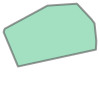

In [13]:
hull

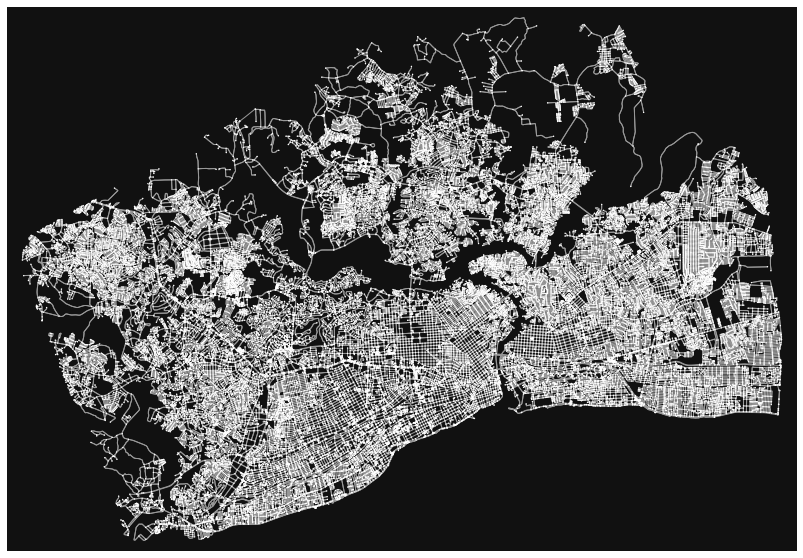

In [25]:
plot = ox.plot_graph(drive, figsize=[20, 10], node_size=2)

In [15]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [16]:
road_links.index = 'osm_link_' + road_links['osmid'].astype(str)
road_nodes.index = 'osm_node_' + road_nodes['osmid'].astype(str)

In [17]:
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes = road_nodes[['geometry']]
road_links[['from', 'to']] = 'osm_node_' + road_links[['from', 'to']].astype(str)

# cleaning

In [18]:
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [19]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

# export 

In [20]:
from quetzal.model.stepmodel import StepModel

sm = StepModel()
sm.road_links = oc.links[['a', 'b', 'length', 'geometry']]
sm.road_nodes = oc.nodes[['geometry']]

In [21]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:49<00:00,  1.55s/it]
